In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import re
import matplotlib.pyplot as plt

import os
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from pathlib import Path

from torch.utils.data import Dataset, DataLoader, random_split
from transformers import DistilBertModel, DistilBertTokenizerFast
from torch.utils.data import DataLoader

### Utils file to import the dataset

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('omw-1.4')

def preprocess_text(text):
    # convert to lower case
    text = text.lower()

    # replace contractions with full words
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    tokens = word_tokenize(text)
    stops = set(stopwords.words('english'))

    filtered_tokens = [
        token for token in tokens
        if token not in stops and token.isalpha()
    ]

    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # 8. Join tokens back into a single string
    return ' '.join(lemmatized_tokens)

def convert_to_sentiment(label):
    if (int(label) <= 2):
        return 'negative'
    elif (int(label) == 3):
        return 'neutral'
    else:
        return 'positive'

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/datasets/test.csv')
df.columns = ['label', 'text']
df['label'] = df['label'].apply(convert_to_sentiment)
df['text'] = df['text'].apply(preprocess_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
df.head()

label                                               text
0  negative  got new tire within two week got flat took car...
1  negative  waste time two different people come house giv...
2  negative  say worst people place lunch place freezing lo...
3  negative  restaurant twice disappointed time go back fir...
4  negative  food good husband ate couple week ago first ti...

### Check data distribution

In [ ]:
# Display the first few rows of the dataframe
print(df.head())

# Display statistics about the dataset
print("\nDataset Statistics:")
print(df['label'].value_counts())

      label                                               text
0  negative  got new tire within two week got flat took car...
1  negative  waste time two different people come house giv...
2  negative  say worst people place lunch place freezing lo...
3  negative  restaurant twice disappointed time go back fir...
4  negative  food good husband ate couple week ago first ti...

Dataset Statistics:
label
negative    20000
positive    20000
neutral     10000
Name: count, dtype: int64


In [ ]:
# Split dataset into training and validation
train_size = int(0.7 * len(df))  # 70% for training
val_size = int(0.15 * len(df))   # 15% for validation
test_size = len(df) - train_size - val_size  # The remaining for testing

### Model Architecture

In [ ]:
class CustomDistilBertForSequenceClassification(nn.Module):
    def __init__(self,dropout=0.3, num_labels=3):
        super(CustomDistilBertForSequenceClassification, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.pre_classifier = nn.Linear(768, 768)  # DistilBERT's hidden size is 768
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, input_ids, attention_mask):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = distilbert_output[0]  # (batch_size, sequence_length, hidden_size)
        pooled_output = hidden_state[:, 0]  # we take the representation of the [CLS] token (first token)
        pooled_output = self.pre_classifier(pooled_output)
        pooled_output = nn.ReLU()(pooled_output)
        pooled_output = self.dropout(pooled_output) # regularization
        logits = self.classifier(pooled_output)
        return logits


### Prepare dataset class

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.dataset = df
        self.tokenizer = tokenizer
        self.max_length = max_length
        # Map sentiments to numerical labels
        self.label_dict = {'negative': 0, 'neutral': 1, 'positive': 2}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        review_text = self.dataset.iloc[idx, 1]  # Assuming reviewText is the first column
        sentiment = self.dataset.iloc[idx, 0]  # Assuming sentiment is the second column
        labels = self.label_dict[sentiment]  # Convert sentiment to numerical label

        # Tokenize the review text
        encoding = self.tokenizer.encode_plus(
          review_text,
          add_special_tokens=True,  # Add [CLS] token at the start for classification
          max_length=self.max_length,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True
        )

        return {
          'review_text': review_text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(), # this is NOT self-attention!
          'labels': torch.tensor(labels, dtype=torch.long)
        }

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
import numpy as np
import time
import random
from itertools import product

log_dir = Path("/content/results")
log_dir.mkdir(parents=True, exist_ok=True)
best_val_loss = float("inf")

def train(dloader, model, criterion, optimizer):
    model.train()
    train_losses, train_accs = [], []

    for batch in tqdm(dloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)


        optimizer.zero_grad()
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        preds = torch.argmax(logits, -1)
        train_accs.append((preds == labels).float().mean().item())

    avg_loss = np.array(train_losses).mean()
    avg_acc = np.array(train_accs).mean()

    print(
        f"Train Loss: {avg_loss:.4f} | Train Accuracy: {avg_acc:.4f}"
    )

    return avg_loss, avg_acc


@torch.no_grad()
def test(dloader, model, criterion):
    model.eval()
    test_losses, test_accs = [], []
    for batch in tqdm(dloader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)


        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        test_losses.append(loss.item())
        preds = torch.argmax(outputs, dim=1)
        test_accs.append((preds == labels).float().mean().item())

    avg_loss = np.array(test_losses).mean()
    avg_acc = np.array(test_accs).mean()

    print(f"Loss: {avg_loss:.4f} | Accuracy: {avg_acc:.4f}")

    return avg_loss, avg_acc

def save_model(model):
    checkpoint_path = log_dir / "best_model.pt"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Best model saved to {checkpoint_path}")

# Reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [ ]:
# define the params
# do hyperparameter tunning here
param_grid = {
    'max_seq_length': [256, 512],
    'dropout': [0.3, 0.5],
}

# Randomly sample combinations
combinations = list(product(*param_grid.values()))
random.shuffle(combinations)
combinations = combinations
EPOCHS = 5

best_val_acc = 0
best_pair = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i, combo in enumerate(combinations):
    print(f"\n🔁 Trial {i+1}: Params = {combo}")
    max_seq_length, dropout = combo

    # prepare the dataset
    review_dataset = ReviewDataset(df, tokenizer, max_seq_length)
    train_dataset, val_dataset, test_dataset = random_split(review_dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=16)

    model = CustomDistilBertForSequenceClassification(dropout=dropout)
    model.to(device)

    # Freeze DistilBERT parameters
    for param in model.distilbert.parameters():
        param.requires_grad = False

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    train_accs, val_accs, test_accs = [], [], []
    train_losses, val_losses, test_losses = [], [], []

    for epoch in range(EPOCHS):
      print(f"===Epoch {epoch}===")
      print("Training...")
      train_loss, train_acc = train(train_loader, model, criterion, optimizer)
      print("Validating...")
      val_loss, val_acc = test(val_loader, model, criterion)

      train_accs.append(train_acc)
      val_accs.append(val_acc)

    val_acc = np.mean(val_accs)
    print(f"Validation Accuracy: {val_acc}")
    if(val_acc > best_val_acc):
        best_val_acc = val_acc
        best_pair = combo
        print(f"best pair currently is {combo}")



🔁 Trial 1: Params = (512, 0.5)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

===Epoch 0===
Training...


Training: 100%|██████████| 469/469 [00:30<00:00, 15.47it/s]


Train Loss: 1.0286 | Train Accuracy: 0.5115
Validating...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.35it/s]


Loss: 1.0018 | Accuracy: 0.5888
===Epoch 1===
Training...


Training: 100%|██████████| 469/469 [00:29<00:00, 15.88it/s]


Train Loss: 0.9756 | Train Accuracy: 0.5855
Validating...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.32it/s]


Loss: 0.9506 | Accuracy: 0.6056
===Epoch 2===
Training...


Training: 100%|██████████| 469/469 [00:29<00:00, 15.92it/s]


Train Loss: 0.9352 | Train Accuracy: 0.6053
Validating...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.34it/s]


Loss: 0.9148 | Accuracy: 0.6180
===Epoch 3===
Training...


Training: 100%|██████████| 469/469 [00:29<00:00, 15.90it/s]


Train Loss: 0.9039 | Train Accuracy: 0.6170
Validating...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.39it/s]


Loss: 0.8840 | Accuracy: 0.6318
===Epoch 4===
Training...


Training: 100%|██████████| 469/469 [00:29<00:00, 15.94it/s]


Train Loss: 0.8750 | Train Accuracy: 0.6288
Validating...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.42it/s]


Loss: 0.8600 | Accuracy: 0.6336
Validation Accuracy: 0.6155650320591958
best pair currently is (512, 0.5)

🔁 Trial 2: Params = (256, 0.3)
===Epoch 0===
Training...


Training: 100%|██████████| 469/469 [00:17<00:00, 27.53it/s]


Train Loss: 1.0394 | Train Accuracy: 0.5122
Validating...


Evaluating: 100%|██████████| 469/469 [00:16<00:00, 28.14it/s]


Loss: 1.0019 | Accuracy: 0.5918
===Epoch 1===
Training...


Training: 100%|██████████| 469/469 [00:16<00:00, 27.64it/s]


Train Loss: 0.9772 | Train Accuracy: 0.5947
Validating...


Evaluating: 100%|██████████| 469/469 [00:16<00:00, 28.14it/s]


Loss: 0.9501 | Accuracy: 0.5991
===Epoch 2===
Training...


Training: 100%|██████████| 469/469 [00:16<00:00, 27.61it/s]


Train Loss: 0.9304 | Train Accuracy: 0.6079
Validating...


Evaluating: 100%|██████████| 469/469 [00:16<00:00, 28.18it/s]


Loss: 0.9110 | Accuracy: 0.6115
===Epoch 3===
Training...


Training: 100%|██████████| 469/469 [00:16<00:00, 27.61it/s]


Train Loss: 0.8951 | Train Accuracy: 0.6250
Validating...


Evaluating: 100%|██████████| 469/469 [00:16<00:00, 28.11it/s]


Loss: 0.8806 | Accuracy: 0.6215
===Epoch 4===
Training...


Training: 100%|██████████| 469/469 [00:17<00:00, 27.55it/s]


Train Loss: 0.8670 | Train Accuracy: 0.6365
Validating...


Evaluating: 100%|██████████| 469/469 [00:16<00:00, 28.05it/s]


Loss: 0.8573 | Accuracy: 0.6274
Validation Accuracy: 0.6102611940806864

🔁 Trial 3: Params = (256, 0.5)
===Epoch 0===
Training...


Training: 100%|██████████| 469/469 [00:17<00:00, 27.58it/s]


Train Loss: 1.0373 | Train Accuracy: 0.4954
Validating...


Evaluating: 100%|██████████| 469/469 [00:16<00:00, 28.11it/s]


Loss: 1.0052 | Accuracy: 0.5609
===Epoch 1===
Training...


Training: 100%|██████████| 469/469 [00:17<00:00, 27.01it/s]


Train Loss: 0.9889 | Train Accuracy: 0.5692
Validating...


Evaluating: 100%|██████████| 469/469 [00:16<00:00, 28.16it/s]


Loss: 0.9593 | Accuracy: 0.5881
===Epoch 2===
Training...


Training: 100%|██████████| 469/469 [00:16<00:00, 27.65it/s]


Train Loss: 0.9489 | Train Accuracy: 0.5947
Validating...


Evaluating: 100%|██████████| 469/469 [00:16<00:00, 28.08it/s]


Loss: 0.9225 | Accuracy: 0.6040
===Epoch 3===
Training...


Training: 100%|██████████| 469/469 [00:17<00:00, 27.56it/s]


Train Loss: 0.9184 | Train Accuracy: 0.6063
Validating...


Evaluating: 100%|██████████| 469/469 [00:16<00:00, 28.09it/s]


Loss: 0.8918 | Accuracy: 0.6139
===Epoch 4===
Training...


Training: 100%|██████████| 469/469 [00:17<00:00, 27.45it/s]


Train Loss: 0.8876 | Train Accuracy: 0.6210
Validating...


Evaluating: 100%|██████████| 469/469 [00:16<00:00, 28.01it/s]


Loss: 0.8669 | Accuracy: 0.6269
Validation Accuracy: 0.5987651031408736

🔁 Trial 4: Params = (512, 0.3)
===Epoch 0===
Training...


Training: 100%|██████████| 469/469 [00:29<00:00, 15.82it/s]


Train Loss: 1.0240 | Train Accuracy: 0.5306
Validating...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.43it/s]


Loss: 0.9893 | Accuracy: 0.5661
===Epoch 1===
Training...


Training: 100%|██████████| 469/469 [00:29<00:00, 16.01it/s]


Train Loss: 0.9668 | Train Accuracy: 0.5836
Validating...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.48it/s]


Loss: 0.9391 | Accuracy: 0.5991
===Epoch 2===
Training...


Training: 100%|██████████| 469/469 [00:29<00:00, 16.08it/s]


Train Loss: 0.9226 | Train Accuracy: 0.6084
Validating...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.52it/s]


Loss: 0.8996 | Accuracy: 0.6171
===Epoch 3===
Training...


Training: 100%|██████████| 469/469 [00:29<00:00, 16.05it/s]


Train Loss: 0.8851 | Train Accuracy: 0.6304
Validating...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.49it/s]


Loss: 0.8686 | Accuracy: 0.6323
===Epoch 4===
Training...


Training: 100%|██████████| 469/469 [00:29<00:00, 16.00it/s]


Train Loss: 0.8590 | Train Accuracy: 0.6407
Validating...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.40it/s]

Loss: 0.8460 | Accuracy: 0.6395
Validation Accuracy: 0.6108475479744135


In [ ]:
print(best_pair)

(512, 0.5)


In [ ]:
review_dataset = ReviewDataset(df, tokenizer, 512)
review_dataset[0]

{'review_text': 'got new tire within two week got flat took car local mechanic see could get hole patched said reason flat previous patch blown wait got tire never needed patched supposed new tire ni took tire flynn told someone punctured tire tried patch resentful tire slasher find unlikely arguing guy telling logic far fetched said would give new tire time ni never go back flynn bc way guy treated simple fact gave used tire',
 'input_ids': tensor([  101,  2288,  2047, 12824,  2306,  2048,  2733,  2288,  4257,  2165,
          2482,  2334, 15893,  2156,  2071,  2131,  4920,  8983,  2098,  2056,
          3114,  4257,  3025,  8983, 10676,  3524,  2288, 12824,  2196,  2734,
          8983,  2098,  4011,  2047, 12824,  9152,  2165, 12824, 13259,  2409,
          2619, 26136, 14890,  2094, 12824,  2699,  8983, 24501,  4765,  3993,
         12824, 18296,  2121,  2424,  9832,  9177,  3124,  4129,  7961,  2521,
         18584,  2098,  2056,  2052,  2507,  2047, 12824,  2051,  9152,  2196,
  

In [ ]:
tokenizer.decode(review_dataset[0]['input_ids'])

'[CLS] got new tire within two week got flat took car local mechanic see could get hole patched said reason flat previous patch blown wait got tire never needed patched supposed new tire ni took tire flynn told someone punctured tire tried patch resentful tire slasher find unlikely arguing guy telling logic far fetched said would give new tire time ni never go back flynn bc way guy treated simple fact gave used tire [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

### Split the dataset and create dataloaders

In [ ]:
train_dataset, val_dataset, test_dataset = random_split(review_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
# Show number of batches
len(train_loader), len(val_loader), len(test_loader)

(2188, 469, 469)

In [ ]:
model = CustomDistilBertForSequenceClassification(dropout=0.5)
model.to(device)

CustomDistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=F

In [ ]:
# Inspect DistilBERT
print(model.distilbert)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

### Freeze the trained params and train only last layers of distilbert

In [ ]:
# Freeze DistilBERT parameters
for param in model.distilbert.parameters():
    param.requires_grad = False

### Training and Validation loop

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Training loop
num_epochs = 10
train_accs, val_accs, test_accs = [], [], []
train_losses, val_losses, test_losses = [], [], []
epoch_times = []

best_test_acc = 0
patience = 2
patience_counter = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    epoch_start_time = time.time()

    # training
    print("Training...")
    train_loss, train_acc = train(train_loader, model, criterion, optimizer)

    # validation
    print("Validating...")
    val_loss, val_acc = test(val_loader, model, criterion)

    # testing
    print("Testing...")
    test_loss, test_acc = test(test_loader, model, criterion)

    # Store accuracies for plotting
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    # Store losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch duration: {epoch_duration:.2f} seconds")
    epoch_times.append(epoch_duration)

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        patience_counter = 0
        #  save the best model
        save_model(model)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break



Epoch 1/10
Training...


Training: 100%|██████████| 2188/2188 [02:16<00:00, 16.05it/s]


Train Loss: 0.9550 | Train Accuracy: 0.5809
Validating...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.49it/s]


Loss: 0.8565 | Accuracy: 0.6412
Testing...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.53it/s]


Loss: 0.8611 | Accuracy: 0.6381
Epoch duration: 193.16 seconds
Best model saved to /content/results/best_model.pt

Epoch 2/10
Training...


Training: 100%|██████████| 2188/2188 [02:16<00:00, 16.05it/s]


Train Loss: 0.8435 | Train Accuracy: 0.6403
Validating...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.54it/s]


Loss: 0.7904 | Accuracy: 0.6612
Testing...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.57it/s]


Loss: 0.7911 | Accuracy: 0.6592
Epoch duration: 192.99 seconds
Best model saved to /content/results/best_model.pt

Epoch 3/10
Training...


Training: 100%|██████████| 2188/2188 [02:16<00:00, 16.07it/s]


Train Loss: 0.8012 | Train Accuracy: 0.6528
Validating...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.56it/s]


Loss: 0.7633 | Accuracy: 0.6677
Testing...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.58it/s]


Loss: 0.7622 | Accuracy: 0.6655
Epoch duration: 192.82 seconds
Best model saved to /content/results/best_model.pt

Epoch 4/10
Training...


Training: 100%|██████████| 2188/2188 [02:16<00:00, 16.08it/s]


Train Loss: 0.7808 | Train Accuracy: 0.6601
Validating...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.51it/s]


Loss: 0.7491 | Accuracy: 0.6740
Testing...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.56it/s]


Loss: 0.7469 | Accuracy: 0.6735
Epoch duration: 192.78 seconds
Best model saved to /content/results/best_model.pt

Epoch 5/10
Training...


Training: 100%|██████████| 2188/2188 [02:16<00:00, 16.04it/s]


Train Loss: 0.7650 | Train Accuracy: 0.6648
Validating...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.53it/s]


Loss: 0.7396 | Accuracy: 0.6763
Testing...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.51it/s]


Loss: 0.7364 | Accuracy: 0.6780
Epoch duration: 193.16 seconds
Best model saved to /content/results/best_model.pt

Epoch 6/10
Training...


Training: 100%|██████████| 2188/2188 [02:16<00:00, 16.05it/s]


Train Loss: 0.7602 | Train Accuracy: 0.6677
Validating...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.49it/s]


Loss: 0.7338 | Accuracy: 0.6776
Testing...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.59it/s]


Loss: 0.7309 | Accuracy: 0.6801
Epoch duration: 193.04 seconds
Best model saved to /content/results/best_model.pt

Epoch 7/10
Training...


Training: 100%|██████████| 2188/2188 [02:16<00:00, 15.99it/s]


Train Loss: 0.7520 | Train Accuracy: 0.6720
Validating...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.43it/s]


Loss: 0.7294 | Accuracy: 0.6807
Testing...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.51it/s]


Loss: 0.7268 | Accuracy: 0.6807
Epoch duration: 193.80 seconds
Best model saved to /content/results/best_model.pt

Epoch 8/10
Training...


Training: 100%|██████████| 2188/2188 [02:16<00:00, 16.05it/s]


Train Loss: 0.7483 | Train Accuracy: 0.6744
Validating...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.54it/s]


Loss: 0.7246 | Accuracy: 0.6821
Testing...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.56it/s]


Loss: 0.7212 | Accuracy: 0.6872
Epoch duration: 193.03 seconds
Best model saved to /content/results/best_model.pt

Epoch 9/10
Training...


Training: 100%|██████████| 2188/2188 [02:16<00:00, 16.07it/s]


Train Loss: 0.7446 | Train Accuracy: 0.6746
Validating...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.54it/s]


Loss: 0.7213 | Accuracy: 0.6819
Testing...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.54it/s]


Loss: 0.7182 | Accuracy: 0.6880
Epoch duration: 192.89 seconds
Best model saved to /content/results/best_model.pt

Epoch 10/10
Training...


Training: 100%|██████████| 2188/2188 [02:16<00:00, 16.05it/s]


Train Loss: 0.7401 | Train Accuracy: 0.6792
Validating...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.52it/s]


Loss: 0.7182 | Accuracy: 0.6857
Testing...


Evaluating: 100%|██████████| 469/469 [00:28<00:00, 16.53it/s]


Loss: 0.7145 | Accuracy: 0.6919
Epoch duration: 193.13 seconds
Best model saved to /content/results/best_model.pt


### Plot training vs validation Accuracy

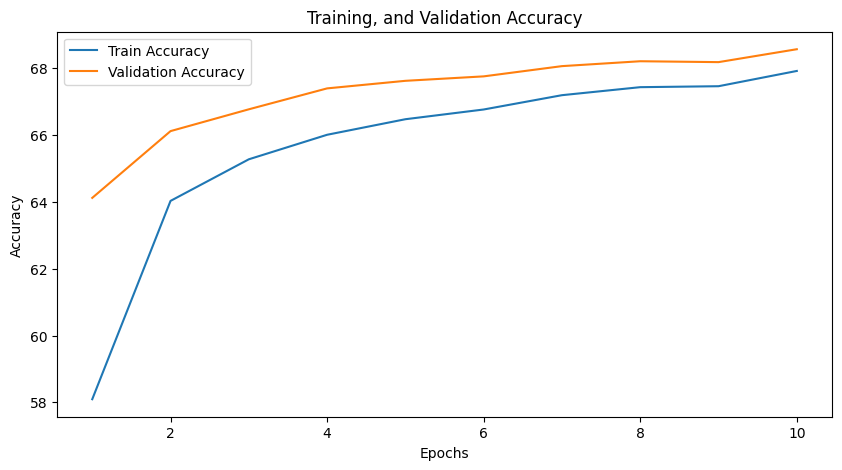

In [ ]:
# Plot training and validation accuracy
train_accs = [i * 100 for i in train_accs]
val_accs = [i * 100 for i in val_accs]
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accs, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accs, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training, and Validation Accuracy")
plt.legend()
plt.show()

### Plot training vs validation losses

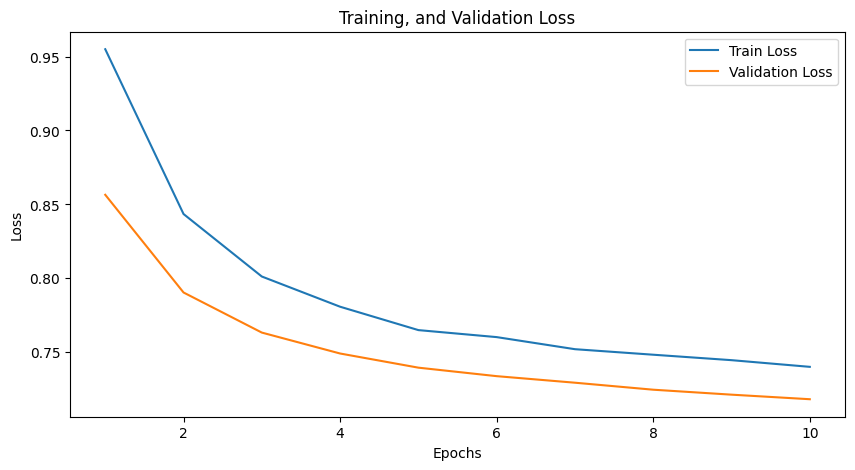

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training, and Validation Loss")
plt.legend()
plt.show()

### Plot Test Accuracy vs Epoch

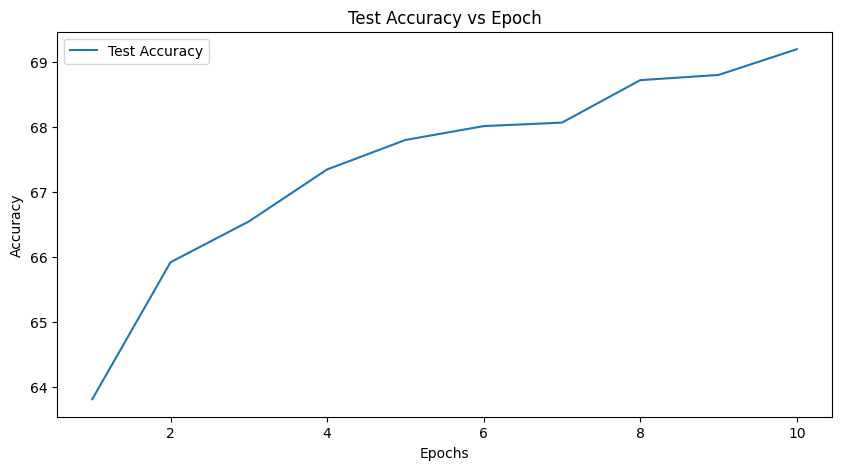

In [ ]:
# Plot test accuracy vs epoch
test_accs = [i * 100 for i in test_accs]
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), test_accs, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test Accuracy vs Epoch")
plt.legend()
plt.show()

### Plot Test Loss vs Epoch

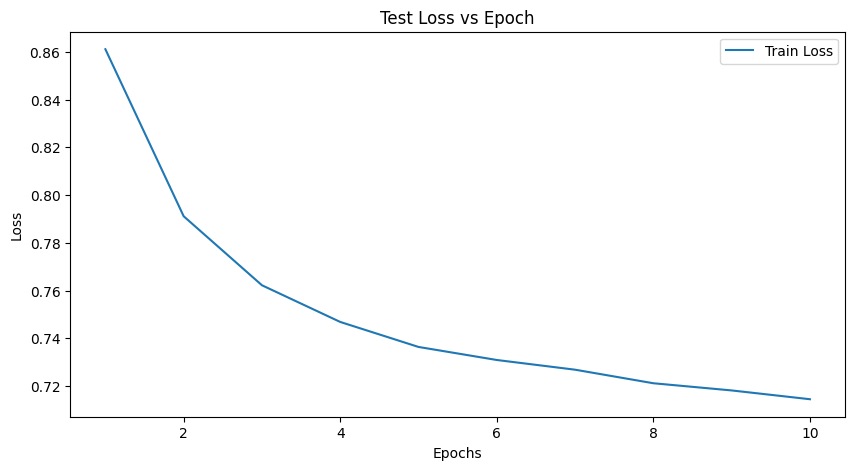

In [ ]:
# Plot test loss vs epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), test_losses, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Test Loss vs Epoch")
plt.legend()
plt.show()

### Save results in a dataframe

In [ ]:
data = {
    'Train Accuracy': train_accs,
    'Validation Accuracy': val_accs,
    'Test Accuracy': test_accs,
    'Train Loss': train_losses,
    'Validation Loss': val_losses,
    'Test Loss': test_losses,
    'Epoch Time': epoch_times
}

df = pd.DataFrame(data)

df.to_csv("distilbert_results.csv")

### Download the saved model

In [ ]:
from google.colab import files

# Specify the path of the file you want to download
file_path = '/content/results/best_model.pt'

# Use files.download() to trigger the download of the file
files.download(file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Inferencing

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize model and load .pt file
model = CustomDistilBertForSequenceClassification()
model.load_state_dict(torch.load("/content/best_model.pt", map_location=torch.device('cpu')))
model.to(device)
model.eval()


CustomDistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=F

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
import numpy as np

def predict_proba(texts):
    inputs = tokenizer.batch_encode_plus(texts.tolist(),
          add_special_tokens=True,
          max_length=512,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True
    ).to(device)
    with torch.no_grad():
        logits = model(inputs["input_ids"], inputs["attention_mask"])
        probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.cpu().numpy()


In [ ]:
sample_reviews = df["text"][9:12]
label = df['label'][9:12]
sample_reviews.tolist(), label

(['stopped mon evening trying dine smoke taqueria closed monday parking street front behind hay st super friendly bartender warmer month huge outdoor area big screen upstairs cornhole game area okay draft beer selection big bottle selection tried italian club really good two u split one also tried sweet potato fry amazingly good home made chip w bleu overpowered sauce bathroom need plaster wall repair grossed toilet brushholder shelf near toilet eye level bet fun place warmer month',
  'think chuck e cheese adult skee ball video game pool table clean environment good funnnunfortunately went bite eat impossible find anything good healthy menu ended settling spinach dip sadly topped dip horrible orange shredded cheese appeared popped microwave second blahhhh trying get something healthy ordered apple pecan salad swear dressing came right grocery store bottle could barely eat salad sweetnnmy mom ordered steak rollholy friedness steak like hamburger fried cheese stuffed breading fried yowz

In [ ]:
import shap

# Create the masker and explainer
masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(predict_proba, masker)

# Generate SHAP values
shap_values = explainer(sample_reviews)


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  67%|██████▋   | 2/3 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [00:23, 11.91s/it]


In [ ]:
shap.plots.text(shap_values)


In [ ]:
shap_text_plot = shap.plots.text(shap_values, display=False)

In [ ]:
with open("shap_text_output.html", "w") as f:
    f.write(shap_text_plot)
